In [10]:
import pandas as pd

# Load the data from the uploaded CSV file
file_path = 'train.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head()


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported,Yes,11000
1,1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,6-Speed M/T,Black,Black,None reported,Yes,8250
2,2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Purple,Beige,None reported,Yes,15000
3,3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Gray,Brown,None reported,Yes,63500
4,4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes,7850


<ipython-input-12-d789984c82e0>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data, x='model_year', y='fuel_type', inner='box', palette='Dark2')


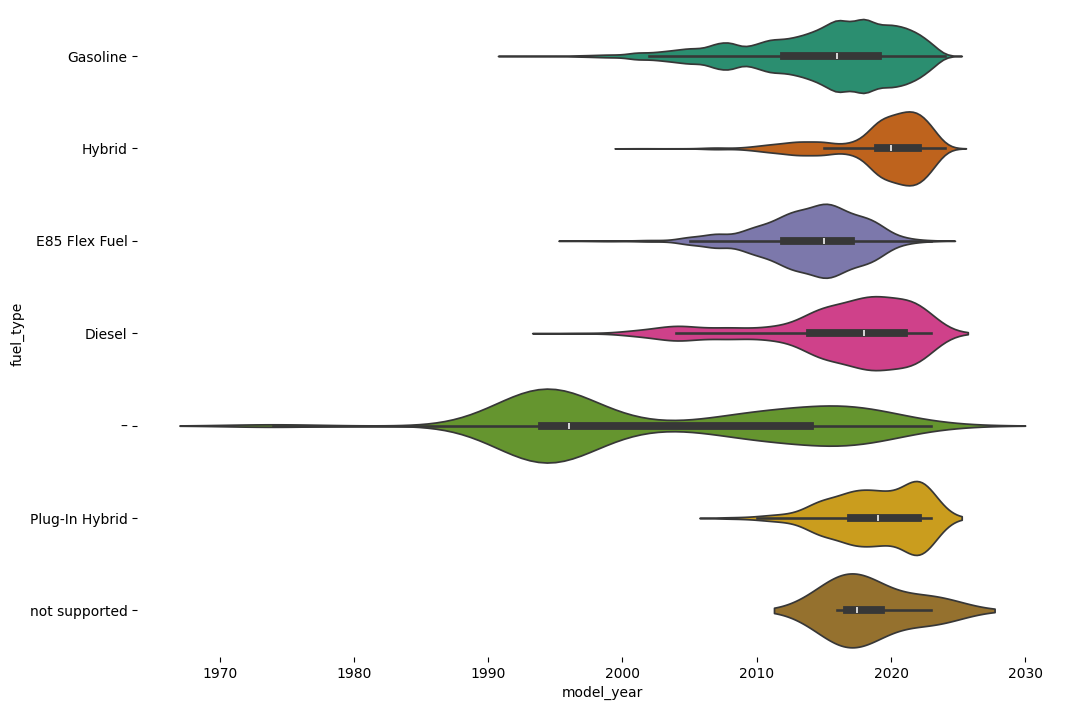

In [12]:
# @title fuel_type vs model_year

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(data['fuel_type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data, x='model_year', y='fuel_type', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

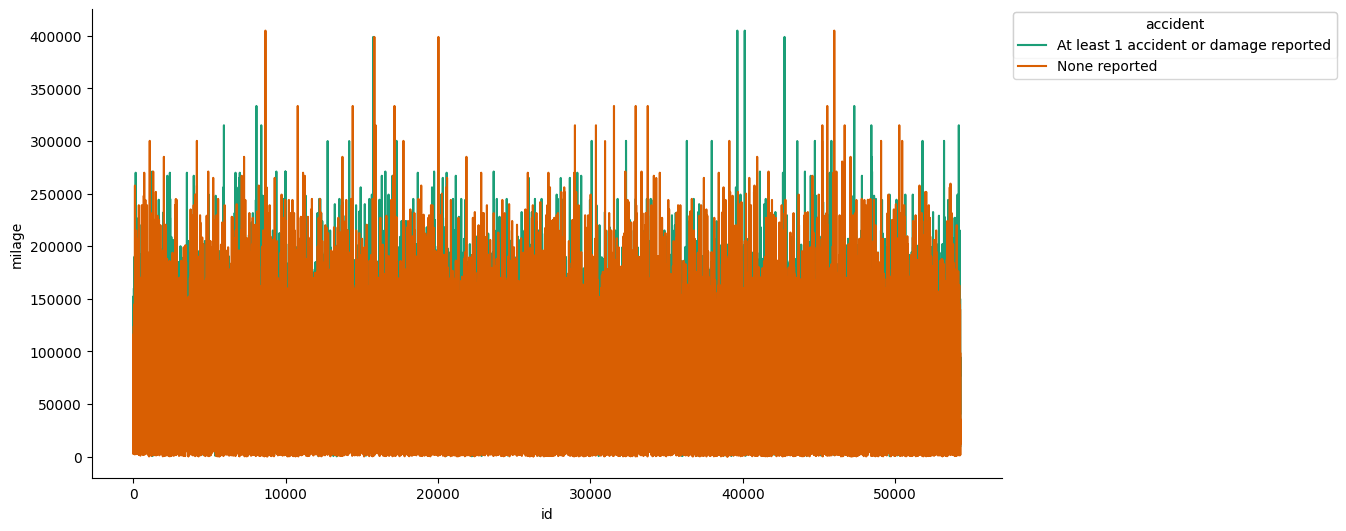

In [11]:
# @title id vs milage

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['id']
  ys = series['milage']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('accident')):
  _plot_series(series, series_name, i)
  fig.legend(title='accident', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('milage')

In [3]:
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


def preprocess_data(data):

    data['milage'] = data['milage'].apply(lambda x: int(re.sub(r'[^\d]', '', x)))


    data['price'] = data['price'].apply(lambda x: int(re.sub(r'[^\d]', '', x)))

    data['clean_title'] = data['clean_title'].fillna('Unknown')


    def extract_hp(engine):
        match = re.search(r'(\d+)\.?\d*\s*HP', engine)
        return int(match.group(1)) if match else np.nan

    data['horsepower'] = data['engine'].apply(extract_hp)

    return data

# Preprocess the data
data_cleaned = preprocess_data(data)

# Separate features and target variable
X = data_cleaned.drop(columns='price')
y = data_cleaned['price']

# Define the column transformer for preprocessing
categorical_features = ['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
numerical_features = ['model_year', 'milage', 'horsepower']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Define the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)


y_pred = model.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

mae, rmse


(17452.66993765586, 133263.40631103373)